In [ ]:
# !pip install wandb

<a id="2"></a>
## <b>1 <span style='color:#B21010'>||</span>Import Library</b>

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import json
import numpy as np
import pandas as pd
import random
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS
import missingno as msno

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

from tensorflow.keras.preprocessing.text import text_to_word_sequence
import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout
from keras.callbacks import ReduceLROnPlateau

from nltk import word_tokenize
from nltk.stem import PorterStemmer

import torch
from torch.utils.data import Dataset

from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline
from transformers import DistilBertTokenizerFast
from transformers import BertForSequenceClassification, BertTokenizerFast
from transformers import TFDistilBertForSequenceClassification, TFTrainingArguments
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import TrainingArguments, Trainer
import wandb

<a id="2"></a>
## <b>2 <span style='color:#B21010'>||</span> EDA + Vis</b>

<a id="3.1"></a>
### <b>2.1 <span style='color:#B21010'>||</span> Load data</b>

In [ ]:
import transformers
import pandas as pd

df =  pd.read_csv('/kaggle/input/data-qna-itk/data qna itk.csv')
df

,Question,Answering,Tag
0,Bagaimana proses pengajuan surat keterangan di...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
1,Langkah apa saja yang perlu diikuti untuk meng...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
2,Apa yang harus dilakukan untuk mendapatkan sur...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
3,Dimana saya bisa mengajukan surat keterangan d...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
4,Apakah ada form online untuk pengajuan surat k...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
...,...,...,...
997,Bagaimana cara mendapatkan bantuan untuk masal...,Jika mengalami kesulitan mengakses layanan UPT...,Layanan Umum-10
998,Apakah UPT ITK menyediakan layanan chat atau e...,Jika mengalami kesulitan mengakses layanan UPT...,Layanan Umum-10
999,Apa yang harus dilakukan jika kesulitan mengak...,Jika mengalami kesulitan mengakses layanan UPT...,Layanan Umum-10
1000,Bagaimana cara memastikan dokumen yang diajuka...,Jika mengalami kesulitan mengakses layanan UPT...,Layanan Umum-10


In [ ]:
df2 = df.copy()
df2.head()

,Question,Answering,Tag
0,Bagaimana proses pengajuan surat keterangan di...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
1,Langkah apa saja yang perlu diikuti untuk meng...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
2,Apa yang harus dilakukan untuk mendapatkan sur...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
3,Dimana saya bisa mengajukan surat keterangan d...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
4,Apakah ada form online untuk pengajuan surat k...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1


<a id="2.3"></a>
### <b>2.3 <span style='color:#B21010'>||</span> Cek Dimensi Dataset</b>

In [ ]:
def print_dimensi_df(df, ds_name="df"):
    print(f"{ds_name} dataset mempunyai {df.shape[0]} baris dan {df.shape[1]} kolom")

print_dimensi_df(df, "Chatbot")

Chatbot dataset mempunyai 1002 baris dan 3 kolom


<a id="2.4"></a>
### <b>2.4 <span style='color:#B21010'>||</span> Informasi Tentang Dataset</b>

In [ ]:
def print_dfInfo(df, ds_name="df"):
    print(f"Informasi Tentang {ds_name} Dataset\n")
    print(df.info())

print_dfInfo(df, "Chatbot")

Informasi Tentang Chatbot Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1002 entries, 0 to 1001
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Question   1002 non-null   object
 1   Answering  1002 non-null   object
 2   Tag        1002 non-null   object
dtypes: object(3)
memory usage: 23.6+ KB
None


<a id="2.5"></a>
### <b>2.5 <span style='color:#B21010'>||</span> Informasi Class Dalam Dataset</b>

In [ ]:
def num_classes(df, target_col, ds_name="df"):
    print(f"{ds_name} dataset mempunyai {len(df[target_col].unique())} kelas")

num_classes(df, 'Tag', "Chatbot")

Chatbot dataset mempunyai 50 kelas


<a id="2.6"></a>
### <b>2.6 <span style='color:#B21010'>||</span> Cek NA atau nilai kosong di dalam dataset</b>

In [ ]:
def check_null(df, ds_name='df'):
    print(f"Cek NA di {ds_name} Dataset:\n")
    print(df.isnull().sum())

check_null(df, "Chatbot")

Cek NA di Chatbot Dataset:

Question     0
Answering    0
Tag          0
dtype: int64


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
# stemmer = PorterStemmer()
ignore_words=['?', '!', ',', '.']

def preprocess_pattern(question):
    words = word_tokenize(question.lower())
    stemmed_words = [word for word in words if word not in ignore_words]
    return " ".join(stemmed_words)

df['Question'] = df['Question'].apply(preprocess_pattern)

In [ ]:
df.head()

,Question,Answering,Tag
0,bagaimana proses pengajuan surat keterangan di...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
1,langkah apa saja yang perlu diikuti untuk meng...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
2,apa yang harus dilakukan untuk mendapatkan sur...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
3,dimana saya bisa mengajukan surat keterangan d...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
4,apakah ada form online untuk pengajuan surat k...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1


<a id="2.8"></a>
### <b>2.8 <span style='color:#B21010'>||</span> Visualisasi Kata-Kata yang Paling Banyak Muncul</b>

In [ ]:
def get_corpus(series):
    words = []
    for text in series:
        for word in text.split():
            words.append(word.strip())
    return words

kata = get_corpus(df.Question)
kata[:5]

['bagaimana', 'proses', 'pengajuan', 'surat', 'keterangan']

In [ ]:
print(f"Dataset mengandung {len(kata)} kata")

Dataset mengandung 10727 kata


In [ ]:
from collections import Counter
counter = Counter(kata)
top_word = counter.most_common(10)
top_word = dict(top_word)
top_word

{'apakah': 605,
 'itk': 484,
 'di': 468,
 'untuk': 347,
 'upt': 324,
 'surat': 285,
 'yang': 282,
 'mahasiswa': 279,
 'bagaimana': 190,
 'bisa': 188}

In [ ]:
def get_top_text_ngrams(kata, n,g):
    vec = CountVectorizer(ngram_range=(1, 1)).fit(kata)
    bag_of_words = vec.transform(kata)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

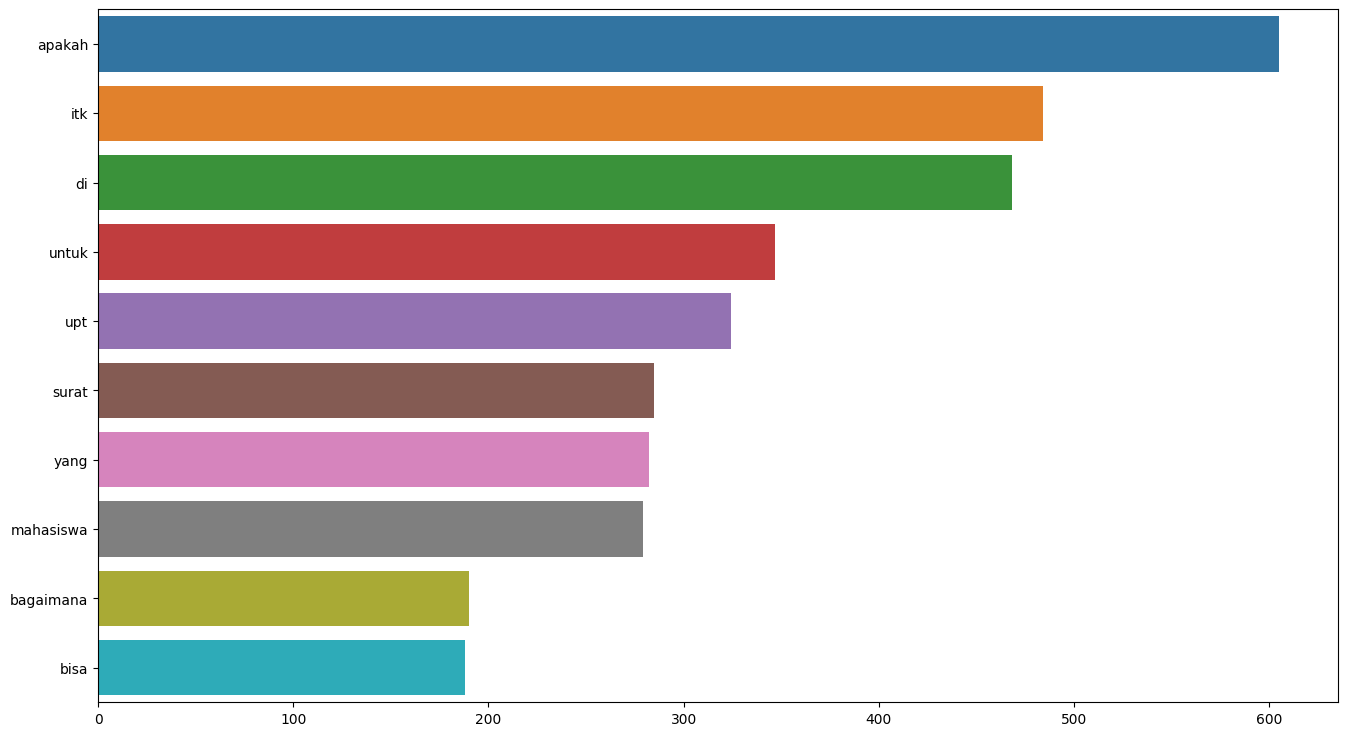

In [ ]:
plt.figure(figsize = (16,9))
most_common_uni = get_top_text_ngrams(df.Question,10,1)
most_common_uni = dict(most_common_uni)
sns.barplot(x=list(most_common_uni.values()),y=list(most_common_uni.keys()));

<a id="3"></a>
## <b>3 <span style='color:#B21010'>||</span> Data Preprocessing</b>

In [ ]:
df2.head()

,Question,Answering,Tag
0,Bagaimana proses pengajuan surat keterangan di...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
1,Langkah apa saja yang perlu diikuti untuk meng...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
2,Apa yang harus dilakukan untuk mendapatkan sur...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
3,Dimana saya bisa mengajukan surat keterangan d...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1
4,Apakah ada form online untuk pengajuan surat k...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1


In [ ]:
labels = df2['Tag'].unique().tolist()
labels = [s.strip() for s in labels]
labels

['Administrasi-1',
 'Administrasi-2',
 'Administrasi-3',
 'Administrasi-4',
 'Administrasi-5',
 'Administrasi-6',
 'Administrasi-7',
 'Administrasi-8',
 'Administrasi-9',
 'Administrasi-10',
 'Administrasi-11',
 'Administrasi-12',
 'Administrasi-13',
 'Administrasi-14',
 'Administrasi-15',
 'Administrasi-16',
 'Administrasi-17',
 'Administrasi-18',
 'Akademik-1',
 'Akademik-2',
 'Akademik-3',
 'Akademik-4',
 'Akademik-5',
 'Akademik-6',
 'Akademik-7',
 'Akademik-8',
 'Akademik-9',
 'Akademik-10',
 'Akademik-11',
 'Akademik-12',
 'Akademik-13',
 'Akademik-14',
 'Akademik-15',
 'Beasiswa-1',
 'Beasiswa-2',
 'Kesehatan-1',
 'Kesehatan-2',
 'Keuangan-1',
 'Keuangan-2',
 'Keuangan-3',
 'Layanan Umum-1',
 'Layanan Umum-2',
 'Layanan Umum-3',
 'Layanan Umum-4',
 'Layanan Umum-5',
 'Layanan Umum-6',
 'Layanan Umum-7',
 'Layanan Umum-8',
 'Layanan Umum-9',
 'Layanan Umum-10']

In [ ]:
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

In [ ]:
id2label

{0: 'Administrasi-1',
 1: 'Administrasi-2',
 2: 'Administrasi-3',
 3: 'Administrasi-4',
 4: 'Administrasi-5',
 5: 'Administrasi-6',
 6: 'Administrasi-7',
 7: 'Administrasi-8',
 8: 'Administrasi-9',
 9: 'Administrasi-10',
 10: 'Administrasi-11',
 11: 'Administrasi-12',
 12: 'Administrasi-13',
 13: 'Administrasi-14',
 14: 'Administrasi-15',
 15: 'Administrasi-16',
 16: 'Administrasi-17',
 17: 'Administrasi-18',
 18: 'Akademik-1',
 19: 'Akademik-2',
 20: 'Akademik-3',
 21: 'Akademik-4',
 22: 'Akademik-5',
 23: 'Akademik-6',
 24: 'Akademik-7',
 25: 'Akademik-8',
 26: 'Akademik-9',
 27: 'Akademik-10',
 28: 'Akademik-11',
 29: 'Akademik-12',
 30: 'Akademik-13',
 31: 'Akademik-14',
 32: 'Akademik-15',
 33: 'Beasiswa-1',
 34: 'Beasiswa-2',
 35: 'Kesehatan-1',
 36: 'Kesehatan-2',
 37: 'Keuangan-1',
 38: 'Keuangan-2',
 39: 'Keuangan-3',
 40: 'Layanan Umum-1',
 41: 'Layanan Umum-2',
 42: 'Layanan Umum-3',
 43: 'Layanan Umum-4',
 44: 'Layanan Umum-5',
 45: 'Layanan Umum-6',
 46: 'Layanan Umum-7',


In [ ]:
label2id

{'Administrasi-1': 0,
 'Administrasi-2': 1,
 'Administrasi-3': 2,
 'Administrasi-4': 3,
 'Administrasi-5': 4,
 'Administrasi-6': 5,
 'Administrasi-7': 6,
 'Administrasi-8': 7,
 'Administrasi-9': 8,
 'Administrasi-10': 9,
 'Administrasi-11': 10,
 'Administrasi-12': 11,
 'Administrasi-13': 12,
 'Administrasi-14': 13,
 'Administrasi-15': 14,
 'Administrasi-16': 15,
 'Administrasi-17': 16,
 'Administrasi-18': 17,
 'Akademik-1': 18,
 'Akademik-2': 19,
 'Akademik-3': 20,
 'Akademik-4': 21,
 'Akademik-5': 22,
 'Akademik-6': 23,
 'Akademik-7': 24,
 'Akademik-8': 25,
 'Akademik-9': 26,
 'Akademik-10': 27,
 'Akademik-11': 28,
 'Akademik-12': 29,
 'Akademik-13': 30,
 'Akademik-14': 31,
 'Akademik-15': 32,
 'Beasiswa-1': 33,
 'Beasiswa-2': 34,
 'Kesehatan-1': 35,
 'Kesehatan-2': 36,
 'Keuangan-1': 37,
 'Keuangan-2': 38,
 'Keuangan-3': 39,
 'Layanan Umum-1': 40,
 'Layanan Umum-2': 41,
 'Layanan Umum-3': 42,
 'Layanan Umum-4': 43,
 'Layanan Umum-5': 44,
 'Layanan Umum-6': 45,
 'Layanan Umum-7': 46,


In [ ]:
df2['labels'] = df2['Tag'].map(lambda x: label2id[x.strip()])
df2.head()

,Question,Answering,Tag,labels
0,Bagaimana proses pengajuan surat keterangan di...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1,0
1,Langkah apa saja yang perlu diikuti untuk meng...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1,0
2,Apa yang harus dilakukan untuk mendapatkan sur...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1,0
3,Dimana saya bisa mengajukan surat keterangan d...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1,0
4,Apakah ada form online untuk pengajuan surat k...,Pengajuan surat keterangan dapat dilakukan den...,Administrasi-1,0


<a id="4"></a>
## <b>4 <span style='color:#B21010'>||</span> Split data training dan testing</b>

In [ ]:
X = list(df2['Question'])
X[:5]

['Bagaimana proses pengajuan surat keterangan di UPT?',
 'Langkah apa saja yang perlu diikuti untuk mengajukan surat keterangan?',
 'Apa yang harus dilakukan untuk mendapatkan surat keterangan?',
 'Dimana saya bisa mengajukan surat keterangan di ITK?',
 'Apakah ada form online untuk pengajuan surat keterangan?']

In [ ]:
y = list(df2['labels'])
y[:5]

[0, 0, 0, 0, 0]

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state = 42)

<a id="5"></a>
## <b>5 <span style='color:#B21010'>||</span> Finetuning Dataset dengan Bert Model</b>

In [ ]:
import torch

bert_model_name = "ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa"
max_len = 256
num_labels = 50

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the tokenizer
tokenizer = BertTokenizer.from_pretrained(bert_model_name, max_length=max_len)

# Load the BERT model
bert_model = BertForSequenceClassification.from_pretrained(
    bert_model_name,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True
)

# Move model to the GPU
bert_model.to(device)

tokenizer_config.json:   0%|          | 0.00/387 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/230k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/476k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/899 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/443M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at ayameRushia/bert-base-indonesian-1.5G-sentiment-analysis-smsa and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([50, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([50]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(32000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

<a id="6.1"></a>
## <b>6.1 <span style='color:#B21010'>||</span> Transform data ke numerik atau angka</b>

In [ ]:
train_encoding = tokenizer(X_train, truncation=True, padding=True)
test_encoding = tokenizer(X_test, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
full_data = tokenizer(X, truncation=True, padding=True)

<a id="6.2"></a>
## <b>6.2 <span style='color:#B21010'>||</span> Membuat Data Loader</b>


In [ ]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [ ]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [ ]:
fullDataLoader = DataLoader(full_data, y_test)

<a id="6.3"></a>
## <b>6.3 <span style='color:#B21010'>||</span> Membuat Function Evaluasi Metrik</b>


In [ ]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

<a id="6.4"></a>
## <b>6.4 <span style='color:#B21010'>||</span> Membuat variabel Training Arguments</b>


In [ ]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="output_bertmodel",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
)

<a id="6.5"></a>
## <b>6.5 <span style='color:#B21010'>||</span> Training Dataset dengan Bert model</b>


In [ ]:
trainer_bertmodel = Trainer(
    model=bert_model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer_bertmodel.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ·························


wandb: ERROR API key must be 40 characters long, yours was 25
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,3.445150,0.318408,0.285186,0.350649,0.371619
2,No log,2.509550,0.681592,0.629093,0.617524,0.712595
3,No log,1.794675,0.805970,0.770734,0.787444,0.826476
4,No log,1.289060,0.825871,0.787757,0.809135,0.838667
5,No log,0.955086,0.860697,0.850292,0.873224,0.870667
6,No log,0.785334,0.880597,0.863336,0.871238,0.890143
7,No log,0.682011,0.865672,0.848049,0.855143,0.874286
8,No log,0.629943,0.860697,0.838350,0.858127,0.863952
9,No log,0.547517,0.890547,0.869761,0.879476,0.891476
10,No log,0.517543,0.890547,0.886969,0.914143,0.894952


TrainOutput(global_step=1300, training_loss=0.31883216857910157, metrics={'train_runtime': 180.1182, 'train_samples_per_second': 222.354, 'train_steps_per_second': 7.217, 'total_flos': 473572658629800.0, 'train_loss': 0.31883216857910157, 'epoch': 50.0})

<a id="6.6"></a>
## <b>6.6 <span style='color:#B21010'>||</span> Evaluate the model</b>


In [ ]:
q=[trainer_bertmodel.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

eval_bert = pd.DataFrame(q, index=["train","test"]).iloc[:,:5]
eval_bert

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.011792,0.997503,0.997606,0.997639,0.997712
test,0.700282,0.860697,0.847238,0.870048,0.864952


In [ ]:
def predict(text):

    inputs = tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = bert_model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = bert_model.config.id2label[pred_label_idx.item()]

    return pred_label_idx, pred_label

In [ ]:
text = "apa ada kuota beasiswa tahun ini di ITK?"
predict(text)

(tensor(34, device='cuda:0'), 'Beasiswa-2')

<a id="6.7"></a>
## <b>6.7 <span style='color:#B21010'>||</span> Save Bert model</b>


In [ ]:
model_path = "chatbot_bert"
trainer_bertmodel.save_model(model_path)
tokenizer.save_pretrained(model_path)

('chatbot_bert/tokenizer_config.json',
 'chatbot_bert/special_tokens_map.json',
 'chatbot_bert/vocab.txt',
 'chatbot_bert/added_tokens.json')

<a id="6.8"></a>
## <b>6.8 <span style='color:#B21010'>||</span> Load Bert model</b>


In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline

model_path = "/kaggle/working/chatbot_bert"


model_bert = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer_bert= AutoTokenizer.from_pretrained(model_path)
chatbot_bert= pipeline("sentiment-analysis", model=model_bert, tokenizer=tokenizer_bert)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
chatbot_bert("apa ada kuota beasiswa tahun ini di ITK?")

[{'label': 'Beasiswa-2', 'score': 0.9862267374992371}]

In [ ]:
pertanyaan = "apa ada kuota beasiswa tahun ini di ITK?"
jawaban = chatbot_bert(pertanyaan)[0]['label']
jawaban

'Beasiswa-2'

<a id="6.9"></a>
## <b>6.9 <span style='color:#B21010'>||</span> Implementasi Chatbot</b>


In [ ]:
def chat_bert(chatbot_bert):

    print("Chatbot: Hi! Saya Virtual Asisten untuk Layanan Informasi di Institut Teknologi Kalimantan")
    print("Ketik 'selesai' untuk keluar\n\n")

    text = input("User: ").strip().lower()

    while text != 'selesai':
        prediction = chatbot_bert(text)[0]
        score = prediction['score']
        predicted_label = prediction['label']

        if score < 0.8:
            print("Chatbot: Maaf, saya masih belum bisa bantu jawab, nanti akan saya tambahkan lagi, terima kasih pertanyaannya\n\n")
        else:
            answer_row = df2[df2['Tag'] == predicted_label]
            response = answer_row.iloc[0]['Answering']
            print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()


In [ ]:
chat_bert(chatbot_bert)

Chatbot: Hi! Saya Virtual Asisten untuk Layanan Informasi di Institut Teknologi Kalimantan
Ketik 'selesai' untuk keluar




User:  apa ada kuota beasiswa tahun ini di ITK?


Chatbot: Informasi kuota beasiswa bisa dilihat di bagian pengumuman di portal beasiswa ITK atau hubungi bagian keuangan untuk informasi lebih lanjut.




User:  bagaimana jika saya ingin mengajukan surat dispensasi?


Chatbot: Waktu pengurusan surat dispensasi biasanya memakan waktu 3-5 hari kerja.




User:  gimana proses pengajuan surat keterangan di upt?


Chatbot: Pengajuan surat keterangan dapat dilakukan dengan mengisi formulir di website UPT ITK dan melampirkan dokumen yang diperlukan.




User:  bagaimana cara mengajukan surat keterangan aktif?


Chatbot: Untuk mengurus surat keterangan aktif, silahkan mengajukan permohonan melalui portal administrasi dan ambil surat di bagian akademik.




User:  selesai


In [ ]:
!zip -r model_bert_itk.zip /kaggle/working/chatbot_bert

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/chatbot_bert/ (stored 0%)
  adding: kaggle/working/chatbot_bert/special_tokens_map.json (deflated 80%)
  adding: kaggle/working/chatbot_bert/vocab.txt (deflated 51%)
  adding: kaggle/working/chatbot_bert/training_args.bin (deflated 51%)
  adding: kaggle/working/chatbot_bert/tokenizer_config.json (deflated 75%)
  adding: kaggle/working/chatbot_bert/config.json (deflated 71%)
  adding: kaggle/working/chatbot_bert/model.safetensors (deflated 7%)


## <b> <span style='color:#B21010'>||</span> Load distilBERT Pretrained model and Tokenizer</b>

In [ ]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

distilbert_model_name = "lxyuan/distilbert-base-multilingual-cased-sentiments-student"
max_len = 256
num_labels = 50

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

distilbert_tokenizer = AutoTokenizer.from_pretrained(distilbert_model_name,
                                          max_length=max_len)

distilbert_model = AutoModelForSequenceClassification.from_pretrained(distilbert_model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id,
                                                      ignore_mismatched_sizes=True)
distilbert_model.to(device)

tokenizer_config.json:   0%|          | 0.00/373 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/759 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at lxyuan/distilbert-base-multilingual-cased-sentiments-student and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([50]) in the model instantiated
- classifier.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([50, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


<a id="7"></a>
## <b>7 <span style='color:#B21010'>||</span> Transform the data into numerical format</b>

In [ ]:
train_encoding = distilbert_tokenizer(X_train, truncation=True, padding=True)
test_encoding = distilbert_tokenizer(X_test, truncation=True, padding=True)

In [ ]:
full_data = distilbert_tokenizer(X, truncation=True, padding=True)

<a id="8"></a>
## <b>8 <span style='color:#B21010'>||</span> Build Data Loader</b>


In [ ]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [ ]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [ ]:
fullDataLoader = DataLoader(full_data, y_test)

<a id="9"></a>
## <b>9 <span style='color:#B21010'>||</span> Define Evaluation Metrcies</b>


In [ ]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

<a id="10"></a>
## <b>10 <span style='color:#B21010'>||</span> Define Training Arguments</b>


In [ ]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="output_distilbertmodel",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
)

<a id="11"></a>
## <b>11 <span style='color:#B21010'>||</span> Train the model</b>


In [ ]:
trainer_distilbertmodel = Trainer(
    model=distilbert_model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer_distilbertmodel.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,3.881376,0.024876,0.013961,0.015013,0.038333
2,No log,3.720387,0.109453,0.071214,0.073947,0.150000
3,No log,3.471939,0.223881,0.172833,0.190982,0.260571
4,No log,3.187656,0.363184,0.316273,0.316523,0.411095
5,No log,2.887177,0.522388,0.479529,0.503112,0.574048
6,No log,2.609465,0.572139,0.540012,0.600497,0.645500
7,No log,2.359133,0.641791,0.600916,0.621224,0.698000
8,No log,2.112972,0.646766,0.611153,0.637321,0.700214
9,No log,1.895975,0.726368,0.696312,0.725569,0.758238
10,No log,1.709174,0.721393,0.689342,0.709346,0.754571


TrainOutput(global_step=1300, training_loss=0.8520124230018029, metrics={'train_runtime': 118.8659, 'train_samples_per_second': 336.934, 'train_steps_per_second': 10.937, 'total_flos': 373349582748000.0, 'train_loss': 0.8520124230018029, 'epoch': 50.0})

<a id="12"></a>
## <b>12 <span style='color:#B21010'>||</span> Evaluate the model</b>


In [ ]:
q=[trainer_distilbertmodel.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

eval_distilbert = pd.DataFrame(q, index=["train","test"]).iloc[:,:5]
eval_distilbert

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.039535,0.997503,0.997592,0.997836,0.997490
test,0.639494,0.855721,0.847863,0.871802,0.866619


In [ ]:
def predict(text):

    inputs = distilbert_tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = distilbert_model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = distilbert_model.config.id2label[pred_label_idx.item()]

    return pred_label_idx, pred_label

In [ ]:
text = "apa ada kuota beasiswa tahun ini di ITK?"
predict(text)

(tensor(34, device='cuda:0'), 'Beasiswa-2')

<a id="13"></a>
## <b>13 <span style='color:#B21010'>||</span> Save the model</b>


In [ ]:
model_path = "chatbot_distilbert"
trainer_distilbertmodel.save_model(model_path)
distilbert_tokenizer.save_pretrained(model_path)

('chatbot_distilbert/tokenizer_config.json',
 'chatbot_distilbert/special_tokens_map.json',
 'chatbot_distilbert/vocab.txt',
 'chatbot_distilbert/added_tokens.json',
 'chatbot_distilbert/tokenizer.json')

<a id="14"></a>
## <b>14 <span style='color:#B21010'>||</span> Load the model</b>


In [ ]:
model_path = "/kaggle/working/chatbot_distilbert"


model_distilbert = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer_distilbert= AutoTokenizer.from_pretrained(model_path)
chatbot_distilbert= pipeline("sentiment-analysis", model=model_distilbert, tokenizer=tokenizer_distilbert)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
chatbot_distilbert("apa ada kuota beasiswa tahun ini di ITK?")

[{'label': 'Beasiswa-2', 'score': 0.9095269441604614}]

<a id="15"></a>
## <b>15 <span style='color:#B21010'>||</span> Chat with the Chatbot</b>


In [ ]:
def chat_distilbert(chatbot_distilbert):

    print("Chatbot: Hi! Saya Virtual Asisten untuk Layanan Informasi di Institut Teknologi Kalimantan")
    print("Ketik 'selesai' untuk keluar\n\n")

    text = input("User: ").strip().lower()

    while text != 'selesai':
        prediction = chatbot_distilbert(text)[0]
        score = prediction['score']
        predicted_label = prediction['label']

        if score < 0.8:
            print("Chatbot: Maaf, saya masih belum bisa bantu jawab, nanti akan saya tambahkan lagi, terima kasih pertanyaannya\n\n")
        else:
            answer_row = df2[df2['Tag'] == predicted_label]
            response = answer_row.iloc[0]['Answering']
            print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()


In [ ]:
chat_distilbert(chatbot_distilbert)

Chatbot: Hi! Saya Virtual Asisten untuk Layanan Informasi di Institut Teknologi Kalimantan
Ketik 'selesai' untuk keluar




User:  apa ada kuota beasiswa tahun ini di ITK?


Chatbot: Informasi kuota beasiswa bisa dilihat di bagian pengumuman di portal beasiswa ITK atau hubungi bagian keuangan untuk informasi lebih lanjut.




User:  bagaimana jika saya ingin mengajukan surat dispensasi?


Chatbot: Waktu pengurusan surat dispensasi biasanya memakan waktu 3-5 hari kerja.




User:  gimana proses pengajuan surat keterangan di upt?


Chatbot: Pengajuan surat keterangan dapat dilakukan dengan mengisi formulir di website UPT ITK dan melampirkan dokumen yang diperlukan.




User:  bagaimana cara mengajukan surat keterangan aktif?


Chatbot: Maaf, saya masih belum bisa bantu jawab, nanti akan saya tambahkan lagi, terima kasih pertanyaannya




User:  selesai


In [ ]:
!zip -r model_distilbert_itk.zip /kaggle/working/chatbot_distilbert

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/chatbot_distilbert/ (stored 0%)
  adding: kaggle/working/chatbot_distilbert/special_tokens_map.json (deflated 80%)
  adding: kaggle/working/chatbot_distilbert/vocab.txt (deflated 45%)
  adding: kaggle/working/chatbot_distilbert/training_args.bin (deflated 51%)
  adding: kaggle/working/chatbot_distilbert/tokenizer_config.json (deflated 73%)
  adding: kaggle/working/chatbot_distilbert/config.json (deflated 71%)
  adding: kaggle/working/chatbot_distilbert/model.safetensors (deflated 7%)
  adding: kaggle/working/chatbot_distilbert/tokenizer.json (deflated 67%)


## <b><span style='color:#B21010'>||</span> Load ROBERTA Pretrained model and Tokenizer</b>

In [ ]:
roberta_model_name = "w11wo/indonesian-roberta-base-sentiment-classifier"
max_len = 256
num_labels = 50

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

roberta_tokenizer = AutoTokenizer.from_pretrained(roberta_model_name,
                                          max_length=max_len)

roberta_model = AutoModelForSequenceClassification.from_pretrained(roberta_model_name,
                                                      num_labels=num_labels,
                                                      id2label=id2label,
                                                      label2id = label2id,
                                                      ignore_mismatched_sizes=True)

roberta_model.to(device)

tokenizer_config.json:   0%|          | 0.00/328 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/808k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/467k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.38M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at w11wo/indonesian-roberta-base-sentiment-classifier and are newly initialized because the shapes did not match:
- classifier.out_proj.bias: found shape torch.Size([3]) in the checkpoint and torch.Size([50]) in the model instantiated
- classifier.out_proj.weight: found shape torch.Size([3, 768]) in the checkpoint and torch.Size([50, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

<a id="7"></a>
## <b>7 <span style='color:#B21010'>||</span> Transform the data into numerical format</b>

In [ ]:
train_encoding = roberta_tokenizer(X_train, truncation=True, padding=True)
test_encoding = roberta_tokenizer(X_test, truncation=True, padding=True)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
full_data = roberta_tokenizer(X, truncation=True, padding=True)

<a id="8"></a>
## <b>8 <span style='color:#B21010'>||</span> Build Data Loader</b>


In [ ]:
class DataLoader(Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)

In [ ]:
train_dataloader = DataLoader(train_encoding, y_train)
test_dataloader = DataLoader(test_encoding, y_test)

In [ ]:
fullDataLoader = DataLoader(full_data, y_test)

<a id="9"></a>
## <b>9 <span style='color:#B21010'>||</span> Define Evaluation Metrcies</b>


In [ ]:
def compute_metrics(pred):

    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)

    return {
        'Accuracy': acc,
        'F1': f1,
        'Precision': precision,
        'Recall': recall
    }

<a id="10"></a>
## <b>10 <span style='color:#B21010'>||</span> Define Training Arguments</b>


In [ ]:
# Define the training arguments
training_args = TrainingArguments(
    output_dir="output_robertamodel",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=16,
    num_train_epochs=50,
    weight_decay=0.01,
)

<a id="11"></a>
## <b>11 <span style='color:#B21010'>||</span> Train the model</b>


In [ ]:
trainer_robertamodel = Trainer(
    model=roberta_model,
    args=training_args,
    train_dataset=train_dataloader,
    eval_dataset=test_dataloader,
    compute_metrics= compute_metrics
)

In [ ]:
trainer_robertamodel.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,3.693143,0.139303,0.090281,0.088142,0.141167
2,No log,3.148796,0.427861,0.401526,0.486916,0.464571
3,No log,2.606663,0.611940,0.569464,0.588230,0.654690
4,No log,2.046021,0.686567,0.663498,0.693024,0.746024
5,No log,1.612337,0.781095,0.754664,0.759206,0.817238
6,No log,1.279164,0.820896,0.806476,0.814849,0.850286
7,No log,1.037761,0.845771,0.832721,0.843230,0.871786
8,No log,0.823550,0.860697,0.831272,0.846048,0.869619
9,No log,0.706678,0.870647,0.841177,0.857214,0.877952
10,No log,0.615146,0.885572,0.873272,0.883786,0.896952


TrainOutput(global_step=1300, training_loss=0.4333335986504188, metrics={'train_runtime': 147.16, 'train_samples_per_second': 272.153, 'train_steps_per_second': 8.834, 'total_flos': 432392427444600.0, 'train_loss': 0.4333335986504188, 'epoch': 50.0})

<a id="12"></a>
## <b>12 <span style='color:#B21010'>||</span> Evaluate the model</b>


In [ ]:
q=[trainer_robertamodel.evaluate(eval_dataset=df2) for df2 in [train_dataloader, test_dataloader]]

eval_roberta = pd.DataFrame(q, index=["train","test"]).iloc[:,:5]
eval_roberta

,eval_loss,eval_Accuracy,eval_F1,eval_Precision,eval_Recall
train,0.011633,0.997503,0.997592,0.997836,0.997490
test,0.605654,0.880597,0.864564,0.883952,0.885619


In [ ]:
def predict(text):

    inputs = roberta_tokenizer(text, padding=True, truncation=True, max_length=512, return_tensors="pt").to("cuda")
    outputs = roberta_model(**inputs)

    probs = outputs[0].softmax(1)
    pred_label_idx = probs.argmax()
    pred_label = roberta_model.config.id2label[pred_label_idx.item()]

    return pred_label_idx, pred_label

In [ ]:
text = "apa ada kuota beasiswa tahun ini di ITK?"
predict(text)

(tensor(34, device='cuda:0'), 'Beasiswa-2')

<a id="13"></a>
## <b>13 <span style='color:#B21010'>||</span> Save the model</b>


In [ ]:
model_path = "chatbot_roberta"
trainer_robertamodel.save_model(model_path)
roberta_tokenizer.save_pretrained(model_path)

('chatbot_roberta/tokenizer_config.json',
 'chatbot_roberta/special_tokens_map.json',
 'chatbot_roberta/vocab.json',
 'chatbot_roberta/merges.txt',
 'chatbot_roberta/added_tokens.json',
 'chatbot_roberta/tokenizer.json')

<a id="14"></a>
## <b>14 <span style='color:#B21010'>||</span> Load the model</b>


In [ ]:
model_path = "/kaggle/working/chatbot_roberta"


model_roberta = AutoModelForSequenceClassification.from_pretrained(model_path)
tokenizer_roberta= AutoTokenizer.from_pretrained(model_path)
chatbot_roberta= pipeline("sentiment-analysis", model=model_roberta, tokenizer=tokenizer_roberta)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [ ]:
chatbot_roberta("Apa ada kuota beasiswa tahun ini di ITK?")

[{'label': 'Beasiswa-2', 'score': 0.708910346031189}]

<a id="15"></a>
## <b>15 <span style='color:#B21010'>||</span> Chat with the Chatbot</b>


In [ ]:
def chat_roberta(chatbot_roberta):

    print("Chatbot: Hi! Saya Virtual Asisten untuk Layanan Informasi di Institut Teknologi Kalimantan")
    print("Ketik 'selesai' untuk keluar\n\n")

    text = input("User: ").strip().lower()

    while text != 'selesai':
        prediction = chatbot_distilbert(text)[0]
        score = prediction['score']
        predicted_label = prediction['label']

        if score < 0.8:
            print("Chatbot: Maaf, saya masih belum bisa bantu jawab, nanti akan saya tambahkan lagi, terima kasih pertanyaannya\n\n")
        else:
            answer_row = df2[df2['Tag'] == predicted_label]
            response = answer_row.iloc[0]['Answering']
            print(f"Chatbot: {response}\n\n")

        text = input("User: ").strip().lower()


In [ ]:
chat_roberta(chatbot_roberta)

Chatbot: Hi! Saya Virtual Asisten untuk Layanan Informasi di Institut Teknologi Kalimantan
Ketik 'selesai' untuk keluar




User:  apa ada kuota beasiswa tahun ini di ITK?


Chatbot: Informasi kuota beasiswa bisa dilihat di bagian pengumuman di portal beasiswa ITK atau hubungi bagian keuangan untuk informasi lebih lanjut.




User:  bagaimana jika saya ingin mengajukan surat dispensasi?


Chatbot: Waktu pengurusan surat dispensasi biasanya memakan waktu 3-5 hari kerja.




User:  gimana proses pengajuan surat keterangan di upt?


Chatbot: Pengajuan surat keterangan dapat dilakukan dengan mengisi formulir di website UPT ITK dan melampirkan dokumen yang diperlukan.




User:  bagaimana cara mengajukan surat keterangan aktif?


Chatbot: Maaf, saya masih belum bisa bantu jawab, nanti akan saya tambahkan lagi, terima kasih pertanyaannya




User:  selesai


In [ ]:
!zip -r model_roberta_itk.zip /kaggle/working/chatbot_roberta

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  adding: kaggle/working/chatbot_roberta/ (stored 0%)
  adding: kaggle/working/chatbot_roberta/vocab.json (deflated 59%)
  adding: kaggle/working/chatbot_roberta/merges.txt (deflated 54%)
  adding: kaggle/working/chatbot_roberta/special_tokens_map.json (deflated 85%)
  adding: kaggle/working/chatbot_roberta/training_args.bin (deflated 51%)
  adding: kaggle/working/chatbot_roberta/tokenizer_config.json (deflated 76%)
  adding: kaggle/working/chatbot_roberta/config.json (deflated 71%)
  adding: kaggle/working/chatbot_roberta/model.safetensors (deflated 7%)
  adding: kaggle/working/chatbot_roberta/tokenizer.json (deflated 72%)
